# R tutorial for [*Lung cancer incidence decreases with elevation: evidence for oxygen as an inhaled carcinogen*](https://doi.org/10.7717/peerj.705)

This tutorial by Daniel Himmelstein recreates some of the main findings from our study. It is written in R. This file is a Jupyter notebook, but you can copy invidual cells into an interactive R terminal.

## Packages

In general, we use the double colon operator to access functions from packages. So for example to specify the `read_tsv` function in the `readr` package, we use `readr::read_tsv()`. This convention avoids polluting our namespace and clarifies function provenance.

This notebook will make use of the following packages, which you may need to install:

+ dplyr
+ readr
+ ggplot2
+ glmnet
+ broom

We do oad dplyr explicitly in order to attach the [pipe operator](http://www.r-statistics.com/2014/08/simpler-r-coding-with-pipes-the-present-and-future-of-the-magrittr-package/) (`%>%`).

In [1]:
library(dplyr, warn = FALSE)

## Read and process data

Here we read the county-level dataset compiled for our study. Each row is a county in the United States.

In [2]:
url = 'https://github.com/dhimmel/elevcan/raw/0330d37345c568250b05aedc3161183589a1edba/data/county-data.txt'
county_df = readr::read_tsv(url)
head(county_df, 2)

,name,state,fips,metro,immigration,native,white,black,male,population,elevation,high_temp,low_temp,diurnal_temp,particulate,precipitation,sunlight,uvb,smoking,smoking_lower,smoking_upper,female_smoking,male_smoking,radon,drinking,meat,diabetes,obesity,education,income,mammogram,all_cancer,all_cancer_male,all_cancer_female,colorectal,colorectal_lower,colorectal_upper,breast,breast_lower,breast_upper,prostate,prostate_lower,prostate_upper,lung,lung_lower,lung_upper,female_lung,male_lung,over_65_lung,under_65_lung
1,"Autauga, AL",AL,01001,1,25.30968,0.9,81.5,17.3,48.59289,43671,0.11012,22.82228,12.95648,9.865793,15.41521,3.703882,16875.17,1180.577,48.6,43.1,54.1,41.05,56.9,0.74,14,74,10.86,29.8,21.7,53.255,69.7,460.6,548.1,407.2,57.1,47.6,67.8,117,99.3,137,119,97.5,143.6,81.5,70.2,94.1,55.8,119.3,398.1,35.7
2,"Baldwin, AL",AL,01003,0,24.94654,1.1,88.1,10.5,49.0318,140415,0.04018,23.87101,15.95164,7.919362,13.35193,4.454666,17407.23,1256.903,49.9,45,54.8,43.75,56.6,0.58,18,69,7.96,25.9,26.8,50.147,69.9,444.9,527.7,374.8,40.7,36.9,44.7,120.2,111.1,129.9,155.1,144.7,166.2,67.9,63.1,73,55,82.8,363.7,25.1


In [3]:
# number of counties
nrow(county_df)

[1] 3142

### Filter counties

Our analysis focused on 10 states that varied substantially in elevation. When designing an experiment, always try to maximize the variation in your variable of interest. We [filtered many counties](https://peerj.com/articles/705/#p-17) for quality control reasons.

In [4]:
states <- c('AZ', 'CA', 'CO', 'ID', 'MT', 'NV', 'NM', 'OR', 'UT', 'WA', 'WY')

county_df = county_df %>%
  dplyr::filter(state %in% states) %>%
  dplyr::filter(population >= 1e4) %>%
  dplyr::filter(native <= 25) %>%
  dplyr::filter(immigration <= 40)

nrow(county_df)

[1] 259

### Add additional variables

We calculate a weight for each county which we use as weights in the regression. The weights account for the increased confidence we have in the measurements for high-population counties. We also calculate the rate of all other cancers besides lung (`no_lung`) to use as a predictor in our model.

In [5]:
county_df = county_df %>%
  dplyr::mutate(no_lung = all_cancer - lung) %>%
  dplyr::mutate(weight = pmin(sqrt(population), 500))

### Create a lung cancer specific dataset

We identified 11 covariates in addition to elevation to assess for lung cancer. Below we create a dataset with only the relevant variables and remove counties with any missing data.

In [6]:
covariates = c(
  'metro',
  'white',
  'black',
  'education',
  'income',
  'obesity',
  'no_lung',
  'male',
  'smoking',
  'radon',
  'particulate')

lung_df = county_df %>%
  dplyr::select(name, lung, elevation, one_of(covariates), weight) %>%
  na.omit()

nrow(lung_df)

[1] 253

## Plot lung cancer versus elevation

This bivariate scatterplot shows the same data as [Figure 4A](https://doi.org/10.7717/peerj.705/fig-4).

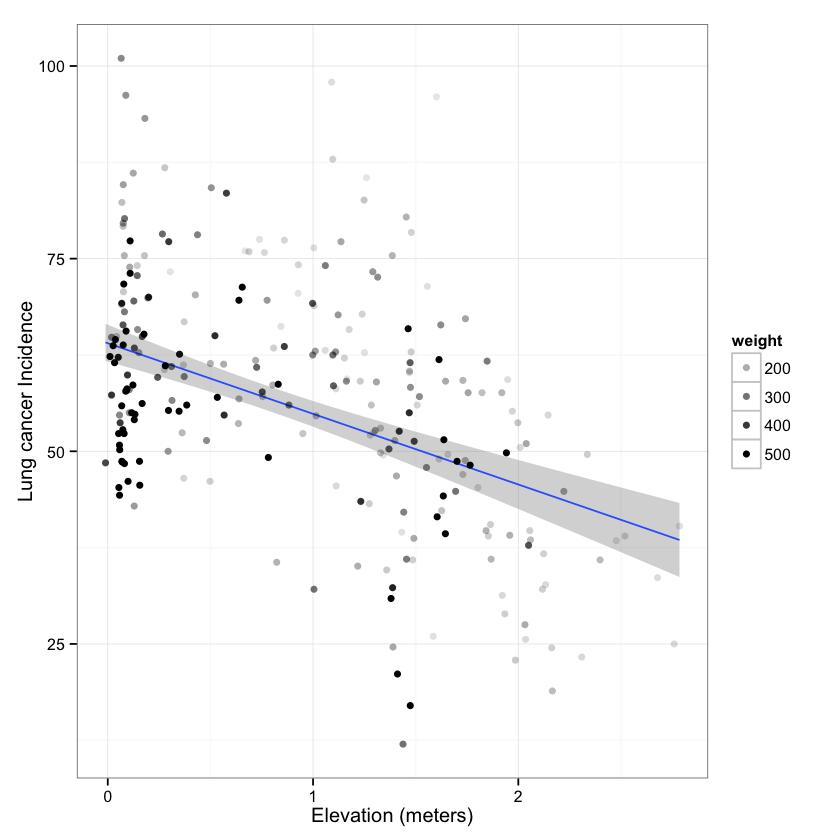

In [7]:
lung_df %>%
  ggplot2::ggplot(ggplot2::aes(x = elevation, y = lung)) +
  ggplot2::geom_smooth(ggplot2::aes(weight = weight), method = 'lm') + 
  ggplot2::geom_point(ggplot2::aes(alpha = weight)) +
  ggplot2::xlab('Elevation (meters)') + ggplot2::ylab('Lung cancer Incidence') +
  ggplot2::theme_bw()

## Best-subset linear model

We used best-subset regression to evaluate all possible predictor combinations. Here we take the predictors from the BIC-minimizing model and fit the linear model.

In [8]:
# Fit the model
model = lm('lung ~ smoking + elevation + no_lung + black + education', data = lung_df, weight = weight)

In [9]:
# View the model coefficients
coef_df = broom::tidy(model)
coef_df

,term,estimate,std.error,statistic,p.value
1,(Intercept),-14.85408,6.779758,-2.190945,0.0293905
2,smoking,1.440257,0.09678763,14.88059,3.460723e-36
3,elevation,-7.234103,0.793121,-9.121059,2.688957e-17
4,no_lung,0.05112451,0.01708235,2.992826,0.003044367
5,black,0.6709068,0.1719983,3.90066,0.000123714
6,education,-0.4334022,0.05503473,-7.875067,1.077715e-13


In [10]:
# Summarize the overall model fit
broom::glance(model)

,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
1,0.7024248,0.6964011,131.2217,116.6085,6.049589e-63,6,-897.7659,1809.532,1834.266,4253129,247


#### Compute standardized coefficients

Standardized coefficients allow us to compare effect sizes between variables. These standardized coefficients are reported in [Figure 3A](https://doi.org/10.7717/peerj.705/fig-3).

In [11]:
weighted.sd <- function(x, w) {
  # Weighted standard deviation
  # http://stats.stackexchange.com/a/6536/74908
  numerator = sum(w * (x - weighted.mean(x, w)) ^ 2)
  M = sum(w != 0)
  denominator = (M - 1) / M * sum(w)
  return(sqrt(numerator / denominator))
}

In [12]:
sd_y = weighted.sd(lung_df$lung, lung_df$weight)
sd_x = apply(lung_df[coef_df$term[-1]], 2, weighted.sd, w = lung_df$weight)
coef_df$estimate[-1] * sd_x / sd_y

smoking  elevation    no_lung      black  education 
 0.5854794 -0.3547520  0.1216339  0.1489461 -0.3039813

## Lasso model

Since the best-subset approach is prone to overfitting, we also fit a lasso model. The lasso model uses cross-validation to find an optimal penalty of complexity, which in effect prevents overfitting.

In [13]:
x_matrix = lung_df %>%
  dplyr::select(elevation, one_of(covariates)) %>%
  as.matrix()
y = lung_df$lung
w = lung_df$weight

# Fit the lasso using cross validation
lasso = glmnet::cv.glmnet(x = x_matrix, y = y, weights = w)

In [14]:
# Coefficients from the lasso model
coef(lasso, s = 'lambda.1se')

13 x 1 sparse Matrix of class "dgCMatrix"
                      1
(Intercept)  0.72552620
elevation   -6.68174482
metro        .         
white        .         
black        0.24769996
education   -0.30998886
income       .         
obesity      .         
no_lung      0.02252882
male         .         
smoking      1.29573258
radon       -0.19956167
particulate  .         

### Calculate lasso R-squared

In [15]:
calculate_R2 <- function(y, y_pred, w) {
  # Calculate R2 using the Sum of Squares method
  # https://en.wikipedia.org/wiki/Coefficient_of_determination#Definitions
  ss_residual = sum(w * (y - y_pred) ^ 2)
  ss_total = sum(w * (y - weighted.mean(y, w)) ^ 2)
  return(1 - ss_residual / ss_total)
}

In [16]:
y_pred = predict(lasso, s = 'lambda.1se', newx = x_matrix)[, 1]
calculate_R2(y, y_pred, w)

[1] 0.6805565

As expected the lasso R-squared is lower than the best-subset R-squared. However, the difference is minimal suggesting overfitting was not a major problem.

## Session info

Added for reproducibility.

In [17]:
sessionInfo()

R version 3.2.2 (2015-08-14)
Platform: x86_64-apple-darwin11.4.2 (64-bit)
Running under: OS X 10.11.3 (El Capitan)

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] dplyr_0.4.3

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.2      plyr_1.8.3       iterators_1.0.8  base64enc_0.1-3 
 [5] tools_3.2.2      digest_0.6.8     uuid_0.1-2       jsonlite_0.9.17 
 [9] evaluate_0.8     gtable_0.1.2     nlme_3.1-122     lattice_0.20-33 
[13] Matrix_1.2-2     psych_1.5.8      foreach_1.4.3    IRdisplay_0.3   
[17] DBI_0.3.1        curl_0.9.5       IRkernel_0.5     parallel_3.2.2  
[21] proto_0.3-10     rzmq_0.7.7       repr_0.3         stringr_1.0.0   
[25] grid_3.2.2       glmnet_2.0-2     R6_2.1.1         ggplot2_1.0.1   
[29] reshape2_1.4.1   readr_0.2.2      tidyr_0.3.1      magrittr_1.5    
[33] codetools_0.2-14 scales_0.3.0     MA